In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be used

In [2]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

# extra dependency, install with: pip install git+https://www.github.com/keras-team/keras-contrib.git
#from keras_contrib.callbacks import CyclicLR

Using TensorFlow backend.


In [3]:
import keras.backend as K
K.set_image_data_format('channels_last')
channel_axis=-1
channel_first = False

# Train? If not, see generated results at the end of the notebook.

In [4]:
TRAIN = False

## Choose folder. I chose mix for this model

In [5]:
foldernames = ['bw_sketches','light_color_watercolor','mix','red']
folders = ['../dataset_williamblake/labeled/' + name for name in foldernames]

In [6]:
paintings_folder = '../dataset_paintings/paintings/boat' + '/*.png'
williamblake_folder = '../dataset_williamblake/labeled/color3' +'/*.jpg'
generation_folder = '../generation_images' + '/*.jpg'

# Define some hyperparameters

In [7]:
# color
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
lambdavar = 10 if use_lsgan else 100

# number of gpus for training
num_gpus = 1
# dropout rate
dropoutRate = 0.2
# ideally: scale the william blake image to the image size during loading and have the final image as 512x512
# but since everything should lose no information going down to 512x512 this is fine
loadSize = 128*2
imageSize = 128*2
# set the batch size to a quarter of the william blake images. There should be no more than a hundred. If there are,
# it is recommended to adjust the batch size to be a percentage of the number of images.

# since mine is exactly 20, use batch size of 20
#batchSize = numBlakeImages // iters
batchSize = 5
epochs = 500
iters = 1

# cyclic learning rate scheme. See https://github.com/bckenstler/CLR for details.
lrD = 5e-5
lrG = 5e-5
momentum = .96

# according to https://github.com/bckenstler/CLR step size should be (2-8) x (training iterations in epoch)
#clrD = CyclicLR(base_lr=lrD, max_lr=3*lrD,
#                        step_size=8*iterPerEpoch)
#clrG = CyclicLR(base_lr=lrG, max_lr=3*lrG,
#                        step_size=8*iterPerEpoch)

# Define network with KERAS API

In [8]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

In [9]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, max_layers=2, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_,)

In [10]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(dropoutRate)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [11]:
netDA = BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
netDA.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
First (Conv2D)               (None, None, None, 64)    3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
zero

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import multi_gpu_model


netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
try:
    print('using multiple gpus')
    netGB = multi_gpu_model(netGB,gpus=num_gpus)
except:
    print('not using multiple gpu')

netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
try:
    print('using multiple gpus')
    netGA = multi_gpu_model(netGA,gpus=num_gpus)
except:
    print('not using multiple gpu')
    
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netGA.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
using multiple gpus
not using multiple gpu
using multiple gpus
not using multiple gpu
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv_256 (Conv2D)               (None, 128, 128, 64) 3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 128, 128, 64) 0           conv_256[0][0]                   
__________________________________________________________________________________________________
conv_12

In [13]:
from keras.optimizers import RMSprop, SGD, Adam

In [14]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

In [15]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [16]:
loss_G = loss_GA+loss_GB+lambdavar*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = SGD(lr=lrG, momentum=momentum,nesterov=False).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = SGD(lr=lrG, momentum=momentum,nesterov=False).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

In [17]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn, is_input=False, grayscale_input=True):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im).astype(float)
    arr=arr/255*2-1
    
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
        
    # grayscale input
    if is_input and grayscale_input:
        img = np.minimum(np.minimum(img[:,:,2],img[:, :,1]), img[:,:,0])
        img = np.broadcast_to(img[...,None],img.shape+(3,))
        
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
        
    return img

train_A = load_data(paintings_folder)
train_B = load_data(williamblake_folder)

assert len(train_A) and len(train_B)

In [18]:
def minibatch(data, batchsize,is_input=False):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j],is_input=is_input) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize,is_input=True)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [19]:
from IPython.display import display
def showX(X, rows=1):
    #assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

In [20]:
# train_batch = minibatchAB(train_A, train_B, 5)

# _, A, B = next(train_batch)
# showX(A)
# showX(B)
#del train_batch, A, B

In [21]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)
    
def showGen(A):
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    print('input image (may not look exactly like the original due to preprocessing)')
    # inp image
    showX(A)
    print('output of the generator')
    showX(rA[0])

In [22]:
from keras.models import model_from_json

def save_models():
    t = 'D'
    for i,model in enumerate([netDA,netDB]):
        # serialize model to JSON
        model_json = model.to_json()
        with open("model" + t + str(i) +".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("model" + t + str(i) +".h5")
        print("Saved D model to disk")

    t = 'G'
    for i,model in enumerate([netGA,netGB]):
        # serialize model to JSON
        model_json = model.to_json()
        with open("model" + t + str(i) +".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("model" + t + str(i) +".h5")
        print("Saved G model to disk")

        
def load_weight(i,char,net):
    net.load_weights("model" + char + str(i) +".h5")

In [23]:
def checkpoints_exist():
    for i in range(1):
        if os.path.exists('modelD0.h5'.format(i)) and os.path.exists('modelG{}.h5'.format(i)):
            continue
        else:
            return False
    return True

In [24]:
if checkpoints_exist():
    t = 'D'
    for i,model in enumerate([netDA,netDB]):
        load_weight(i,t,model)
    t = 'G'
    for i,model in enumerate([netGA,netGB]):
        load_weight(i,t,model)

#     for i in range(10):
#         _, A, B = train_batch.send(2)
    print('loaded from .h5 files')
#     showG(A,B)

loaded from .h5 files


In [25]:
def train(epochs):
    import time
    from IPython.display import clear_output

    errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

    display_epochs = 100
    save_epochs = 400
    train_batch = minibatchAB(train_A, train_B, batchSize)

    for epoch in range(epochs+1): 
        for niter in range(iters):
            _, A, B = next(train_batch)        
            errDA, errDB  = netD_train([A, B])
            errDA_sum += errDA / iters
            errDB_sum += errDB / iters

            for i in range(2):
                errGA, errGB, errCyc = netG_train([A, B])
                errGA_sum += errGA / (2*iters)
                errGB_sum += errGB / (2*iters)
                errCyc_sum += errCyc / (2*iters)
                
        # check if loss is converging and print current output
        if epoch%display_epochs==0:
                #if gen_iterations%(5*display_epochs)==0:
                clear_output()
                print('[%dth epoch] out of [%d epochs] Loss_D: %f %f Loss_G: %f %f loss_cyc'
                % (epoch, epochs, errDB_sum/display_epochs,
                   errGA_sum/display_epochs, errGB_sum/display_epochs, 
                   errCyc_sum/display_epochs))
                _, A, B = train_batch.send(4)
                showG(A,B)
                errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
            
def generate(gen_A,n_generate):    
    print(len(train_B))
    train_batch = minibatchAB(gen_A, train_B, min(len(gen_A),len(train_B)))

    
    for i in range(n_generate):
        next(train_batch)
        _, A, B = train_batch.send(1)
        
        #showG(A,B)
        showGen(A)

## Displayed in the order of: image A, image B, generated image
- To download results, should be able to right click (or shift+right click) save image

## The model will always create a set image for a given input. The B does not matter.

In [26]:
# get results
if TRAIN:
    train(epochs)
    save_models()

6
input image (may not look exactly like the original due to preprocessing)


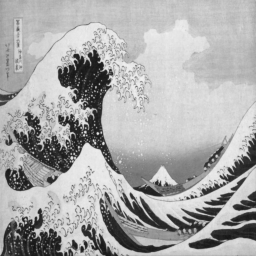

output of the generator


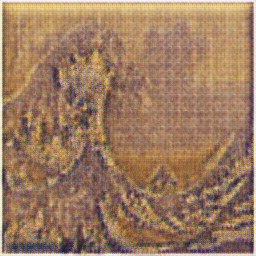

input image (may not look exactly like the original due to preprocessing)


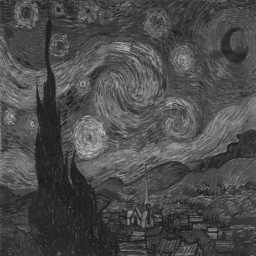

output of the generator


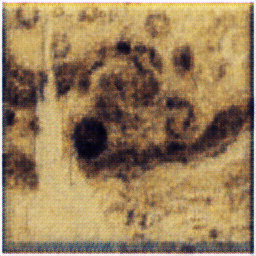

input image (may not look exactly like the original due to preprocessing)


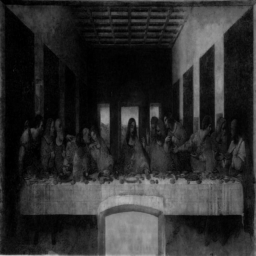

output of the generator


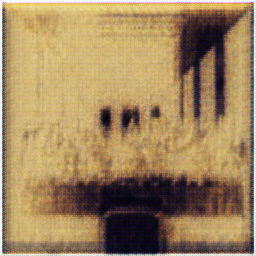

input image (may not look exactly like the original due to preprocessing)


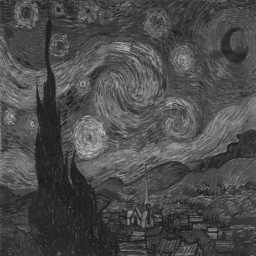

output of the generator


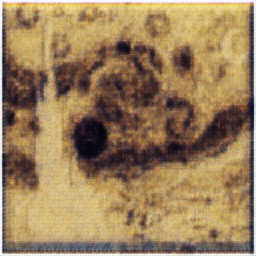

input image (may not look exactly like the original due to preprocessing)


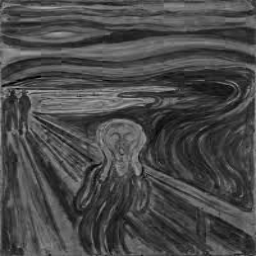

output of the generator


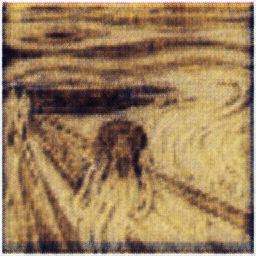

input image (may not look exactly like the original due to preprocessing)


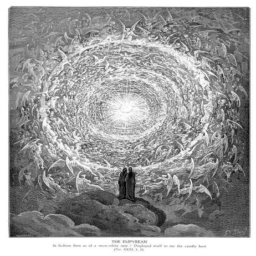

output of the generator


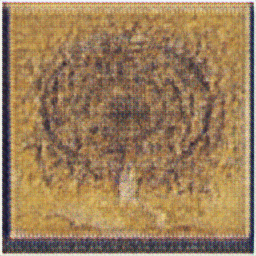

input image (may not look exactly like the original due to preprocessing)


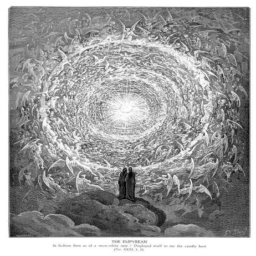

output of the generator


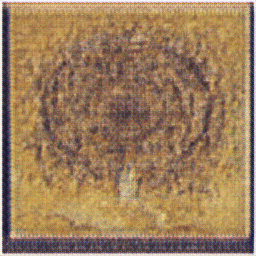

input image (may not look exactly like the original due to preprocessing)


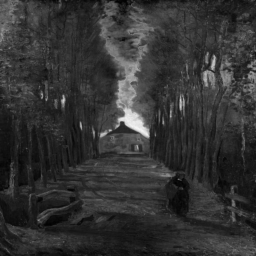

output of the generator


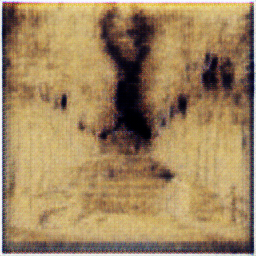

In [27]:
gen_A = load_data(generation_folder)

generate(gen_A,len(gen_A))